In [1]:
import torch
from torch import nn, optim

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

from model import GraphNet
from data_utils import ML100KDataset

In [2]:
dataset = ML100KDataset()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = GraphNet([32, 32], 1, 5, dropout_conv=0.0, dropout_lin=0.0, device=device)
# model = GraphNet([16, 16, 16, 16, 16, 16], 1, 5)

In [5]:
sum([p.numel() for p in model.parameters()])

23617

##### train func

In [6]:
def train(model, dataset, optimizer, criterion, h_hops, n_epochs, batch_size, lam=1e-3):
    losses = []
    sim_losses = []
    model.train(True)

    MAXITER = 10000 #len(dataset)
    for e in tqdm(range(n_epochs)):
        shape = (MAXITER//batch_size, batch_size)
        permutation = torch.randperm(MAXITER)[:shape[0]*shape[1]]
        permutation = permutation.reshape(shape)
        pbar = tqdm(permutation, leave=False)
        for batch in pbar:
            # zero gradients
            optimizer.zero_grad()
            # prepare empty lists
            predictions = torch.empty(batch_size)
            ground_truths = torch.empty(batch_size)
            for iteration, index in enumerate(batch):
                # get data
                data, target_nodes, r = dataset[index]
                # get prediction
                r_hat = model(*data, *target_nodes)
                ground_truths[iteration] = r
                predictions[iteration] = r_hat
            # calculate loss
            crit_loss = criterion(predictions, ground_truths)
            sim_loss = torch.tensor(0.)
            for i in range(model.network_depth):
                layer = model.get_submodule(f'conv{i}.module_0')
                w = layer.get_parameter('weight')
                for k in range(5-1):
                    sim_loss += torch.nn.functional.mse_loss(w[k], w[k+1])
            
            loss = crit_loss + lam*sim_loss
            loss.backward()
            optimizer.step()
            
            losses.append(crit_loss.item())            
            sim_losses.append(sim_loss.item())
            pbar.set_description(f'{losses[-1]:1.4f}')
    model.train(False)
    return losses, sim_losses

##### back

In [7]:
l, sl = train(
    model,
    dataset,
    optim.Adam(model.parameters(), lr=1e-3, weight_decay=0),#1e-5),
    nn.MSELoss(),
    1,
    2,
    64,
    lam=1e-3
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

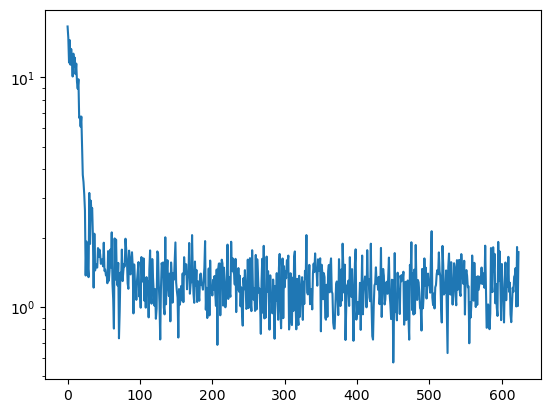

In [11]:
fig, ax = plt.subplots(1)
ax.plot(l)
# ax.plot(sl)
ax.set_yscale('log')
plt.show()

In [9]:
### test
for i in range(10):
    with torch.no_grad():
        data, target_nodes, r = dataset[i]
        # separate data
        x, edge_index, rating = data
        edge_type = rating - 1
        tgt_u, tgt_m = target_nodes
        
        # edge_index = edge_index[[1,0]]
        # print(edge_index[:,:10])
        
        # zero gradients
        # get prediction
        r_hat = model(
            x,
            edge_index,
            edge_type,
            tgt_u,
            tgt_m
        )
        print(r, r_hat, torch.nn.functional.mse_loss(r.float(), r_hat.squeeze()))

tensor(5) tensor([3.2553]) tensor(3.0439)
tensor(3) tensor([3.1649]) tensor(0.0272)
tensor(4) tensor([3.0729]) tensor(0.8595)
tensor(3) tensor([3.2149]) tensor(0.0462)
tensor(3) tensor([3.0026]) tensor(6.5336e-06)
tensor(4) tensor([3.2269]) tensor(0.5977)
tensor(1) tensor([3.2269]) tensor(4.9591)
tensor(5) tensor([3.1789]) tensor(3.3163)
tensor(2) tensor([3.2348]) tensor(1.5249)
tensor(5) tensor([3.1442]) tensor(3.4439)
